### Проект: вариант 4
### Задание 1

Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories).
Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика
Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

**Данные:**

- `active_users` – информация о пользователях, которые посещали приложение во время эксперимента. 
- `groups` – разбивка пользователей на контрольную (А) и тестовую (В) группы. 
- `purchases` – данные о транзакциях (оплатах) пользователей приложения во время эксперимента .

## Содержание:

- [Загрузка данных](#open)
- [Таблица active_users](#active_users)
- [Таблица groups](#groups)
- [Таблица purchases](#purchases)
- [Объединение таблиц](#merge)
- [Изучение данных](#data_research)
- [Распределение выручки](#graph)    
- [Выбор метрик](#metrica)
- [Средняя выручка с заплатившего пользователя](#mean)
- [Применение Bootstrap](#boot)
- [ARPU](#m_2)
- [Медианная выручка с заплатившего пользователя](#median)
- [Выводы](#con)


In [4]:
# подгружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(22,8)}
)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, mannwhitneyu, levene, shapiro
from tqdm.auto import tqdm
import statsmodels.api as sm

### Загрузка данных: <a id='open'></a>

In [5]:
#подгружаем данные
active_users = pd.read_csv('Проект_4_active_users.csv')
groups = pd.read_csv('Проект_4_groups.csv')
purchases = pd.read_csv('Проект_4_purchases.csv')

### active_users <a id='active_users'></a>
информация о пользователях, которые посещали приложение во время эксперимента.

In [6]:
print('Проверка на соответствие типов данных:','\n',active_users.dtypes)
print('Проверка на дублированные ID:','\n',active_users.user_id.nunique() != active_users.user_id.count())
print('Проверка на отсутвующие значения:','\n', active_users.isna().sum())
active_users.head()

Проверка на соответствие типов данных: 
 user_id      int64
country     object
platform    object
sex         object
dtype: object
Проверка на дублированные ID: 
 False
Проверка на отсутвующие значения: 
 user_id     0
country     0
platform    0
sex         0
dtype: int64


,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


### groups <a id='groups'></a>
разбивка пользователей на контрольную (А) и тестовую (В) группы

In [7]:
print('Проверка на соответствие типов данных:','\n',groups.dtypes)
print('Проверка на дублированные ID:','\n',groups.user_id.nunique() != groups.user_id.count())
print('Проверка на отсутвующие значения:','\n', groups.isna().sum())
groups.head()

Проверка на соответствие типов данных: 
 user_id     int64
group      object
dtype: object
Проверка на дублированные ID: 
 False
Проверка на отсутвующие значения: 
 user_id    0
group      0
dtype: int64


,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


### purchases <a id='purchases'></a>
Данные о транзакциях (оплатах) пользователей приложения во время эксперимента


In [8]:
print('Проверка на соответствие типов данных:','\n',purchases.dtypes)
print('Проверка на дублированные ID:','\n',purchases.user_id.nunique() != purchases.user_id.count())
print('Проверка на отсутвующие значения:','\n', purchases.isna().sum())
purchases.head()

Проверка на соответствие типов данных: 
 user_id      int64
revenue    float64
dtype: object
Проверка на дублированные ID: 
 False
Проверка на отсутвующие значения: 
 user_id    0
revenue    0
dtype: int64


,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [9]:
purchases.revenue.min()

207.0

Колонки названы удобно, типы данных соответствуют самим данным, повторных id нет, пропущенных значений также нет.

Попробуем соединить таблицы за основу возьмём таблицу **purchases**, потому что именно эти пользователи совершали покупки, а значит, именно их поведение нам интересно. Соответственно, при left join с таблицей **groups** часть пользователей, не совершавшая активных покупок на протяжении периода проведения эксперимента, будет отсечена.

А для объединения с таблицей **users** нам нужно прежде выяснить, все ли `user_id` из **purchases** содержатся в **users**.

In [10]:
purchases.merge(active_users, how='outer', on='user_id').query('revenue > 0')

,user_id,revenue,country,platform,sex
0,4412,1000.0,Russia,android,female
1,9000,701.0,NaN,NaN,NaN
2,9001,700.0,NaN,NaN,NaN
3,9002,702.0,NaN,NaN,NaN
4,5790,1002.0,Sweden,android,male
...,...,...,...,...,...
536,5648,1908.0,Sweden,android,female
537,2277,1912.0,Sweden,ios,female
538,5032,1911.0,Sweden,ios,male
539,908,1910.0,Sweden,android,male


In [11]:
active_users_purchases= purchases.merge(active_users, how='inner', on='user_id')
active_users_purchases.user_id.value_counts().sum()

392

In [12]:
active_users_purchases= purchases.merge(active_users, how='outer', on='user_id').query('revenue > 0')

In [14]:
groups.user_id.count()

74576

Только **392** из **541** user_id в `purchases` содержатся в `users`.

В таблице `groups` **74576** значений ID.

Это может означать, что есть пользователи, которые совершали оплату без входа в приложение.

Исключим этих пользователей, т.к. они не отвечают требованию о пользовании моделью оплаты в приложении.

### Создадим объединенную таблицу <a id='merge'></a>
Поместим в нее всех пользователей

In [15]:
#Общая
sum_df = active_users.merge(groups, how='left', on='user_id').merge(purchases, how='left', on='user_id')
sum_df

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,NaN
8337,3755,Russia,ios,male,A,590.0
8338,4594,Sweden,android,female,B,NaN
8339,7430,Sweden,ios,female,B,NaN


Также нужно проверить, есть ли пользователи, которые выполнили требование эксперимента (вошли в приложение, совершили покупку) но не были определены в тестовую/контрольную группу.

In [16]:
#отфильтрованная для анализа
active_users_purchases_gr = active_users_purchases.merge(groups, how='left', on='user_id')
print('Cовершили покупку, но не были определены в тестовую/контрольную группу?','\n',active_users_purchases_gr.group.count().sum() != active_users_purchases.user_id.value_counts().sum())
active_users_purchases_gr

Cовершили покупку, но не были определены в тестовую/контрольную группу? 
 False


,user_id,revenue,country,platform,sex,group
0,4412,1000.0,Russia,android,female,A
1,9000,701.0,NaN,NaN,NaN,B
2,9001,700.0,NaN,NaN,NaN,B
3,9002,702.0,NaN,NaN,NaN,B
4,5790,1002.0,Sweden,android,male,B
...,...,...,...,...,...,...
536,5648,1908.0,Sweden,android,female,B
537,2277,1912.0,Sweden,ios,female,B
538,5032,1911.0,Sweden,ios,male,B
539,908,1910.0,Sweden,android,male,B


### Изучение данных <a id='data_research'></a>

Разобьём данные на контрольную и тестовую группы

In [17]:
control = sum_df[sum_df.group == 'A'].reset_index(drop=True)
test = sum_df[sum_df.group == 'B'].reset_index(drop=True)

## Посмотрим как были разбиты группы:

- [Пол](#mv)
- [Страна](#count)
- [Платформа](#plat)

### Разбиение по полу: <a id='mv'></a>

,group,sex,user_id
0,A,female,753
1,A,male,785
2,B,female,3392
3,B,male,3411


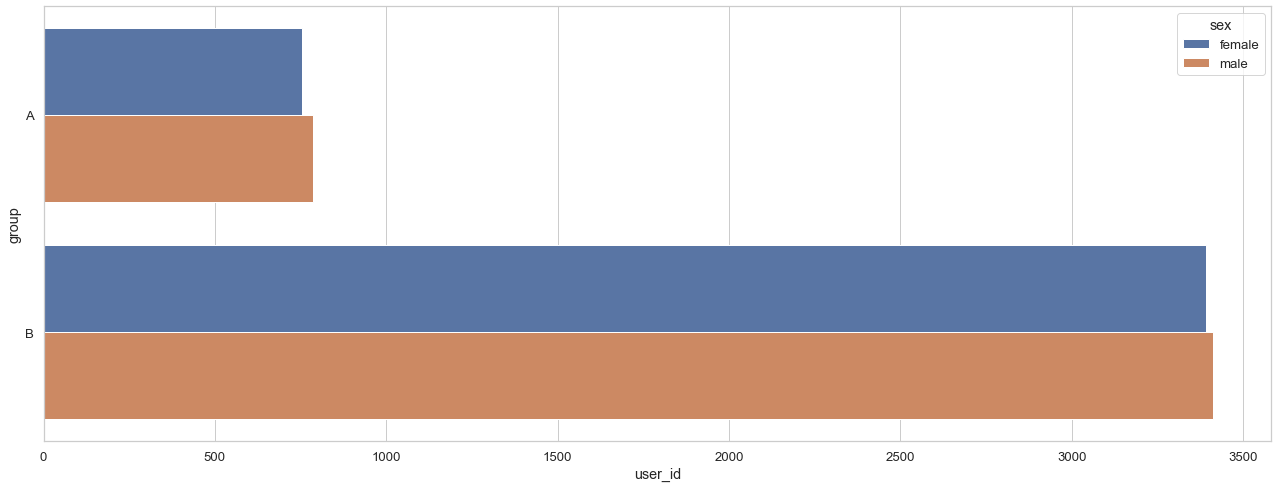

In [19]:
mw = sum_df.groupby(['group', 'sex'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=mw.user_id, y=mw.group, hue=mw.sex)
mw

Мужчин и женщин примерно поровну в обеих группах.

### Разбиение по странам: <a id='Count'></a>

,group,country,user_id
0,A,Russia,915
1,A,Sweden,623
2,B,Russia,4492
3,B,Sweden,2311


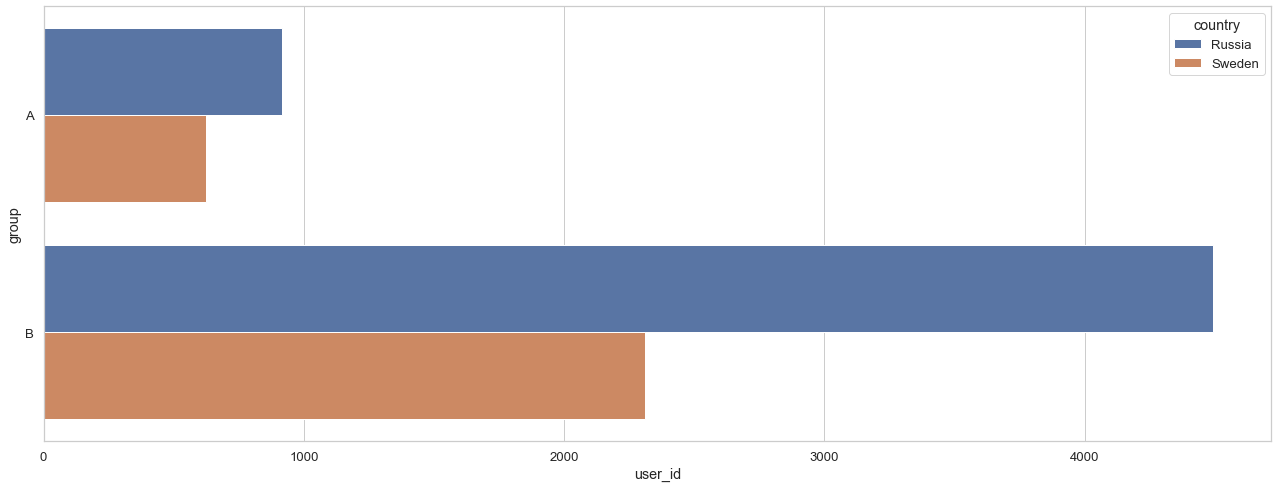

In [20]:
country = sum_df.groupby(['group', 'country'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=country.user_id, y=country.group, hue=country.country)
country

В распределении по странам перекос : в  группе A(тестовой) россиян примерно в 1,5 раза больше, чем шведов, а в группе В - почти в два раза.

,group,country,user_id
0,A,Russia,43
1,A,Sweden,35
2,B,Russia,197
3,B,Sweden,117


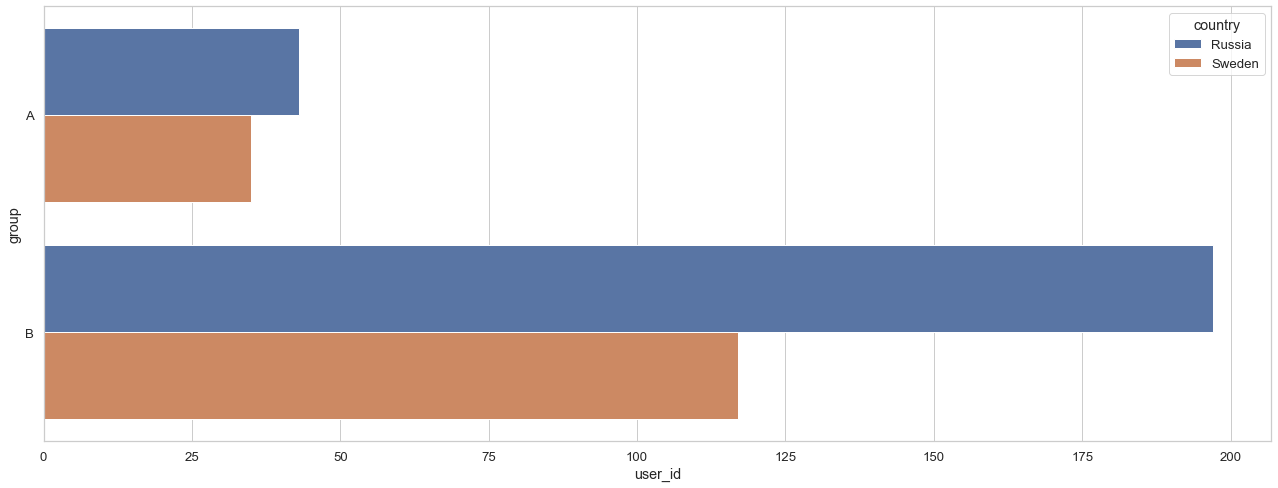

In [21]:
#Разбиение по странам в датафрейме с активными и оптлаившими пользователями
df = active_users_purchases_gr.groupby(['group', 'country'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=df.user_id, y=df.group, hue=df.country)
df

Среди активных и оплативших пользователей ситуация схожая - похоже при сплитовании произошла ошибка.

### Разбиение по платформе: <a id='plat'></a>

,group,platform,user_id
0,A,android,834
1,A,ios,704
2,B,android,3787
3,B,ios,3016


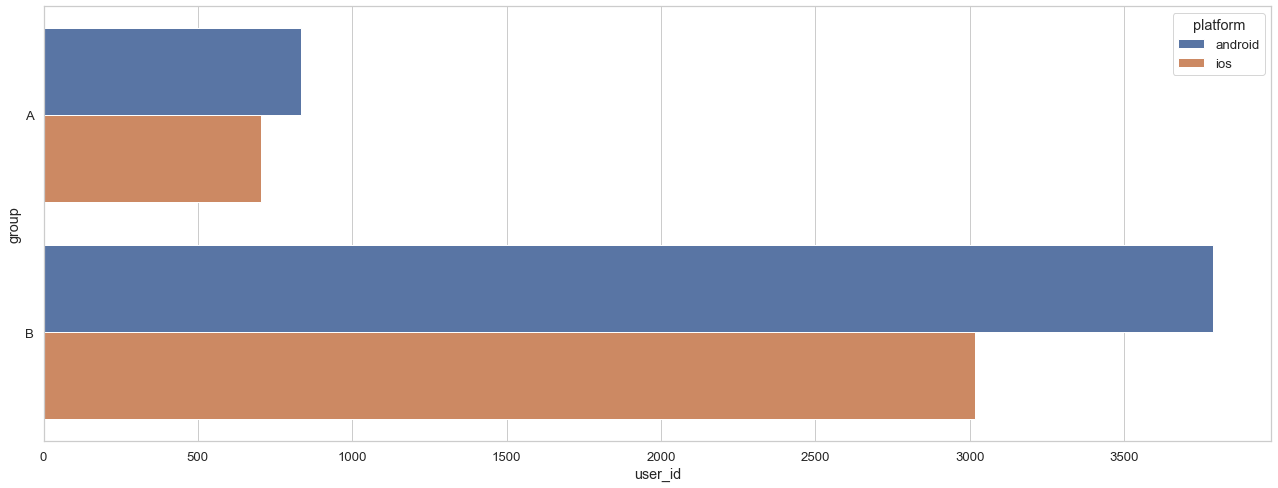

In [22]:
platform = sum_df.groupby(['group', 'platform'], as_index=False).agg({'user_id': 'count'})
sns.barplot(x=platform.user_id, y=platform.group, hue=platform.platform)
platform

В обеих группах  есть небольшой перекос в сторону платформы Android

### График распределения выручки заплативших пользователей <a id='graph'></a>

In [24]:
ac_control = sum_df[(sum_df.group == 'A') & (sum_df.revenue > 0)].reset_index(drop=True)
ac_test = sum_df[(sum_df.group == 'B') & (sum_df.revenue > 0)].reset_index(drop=True)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

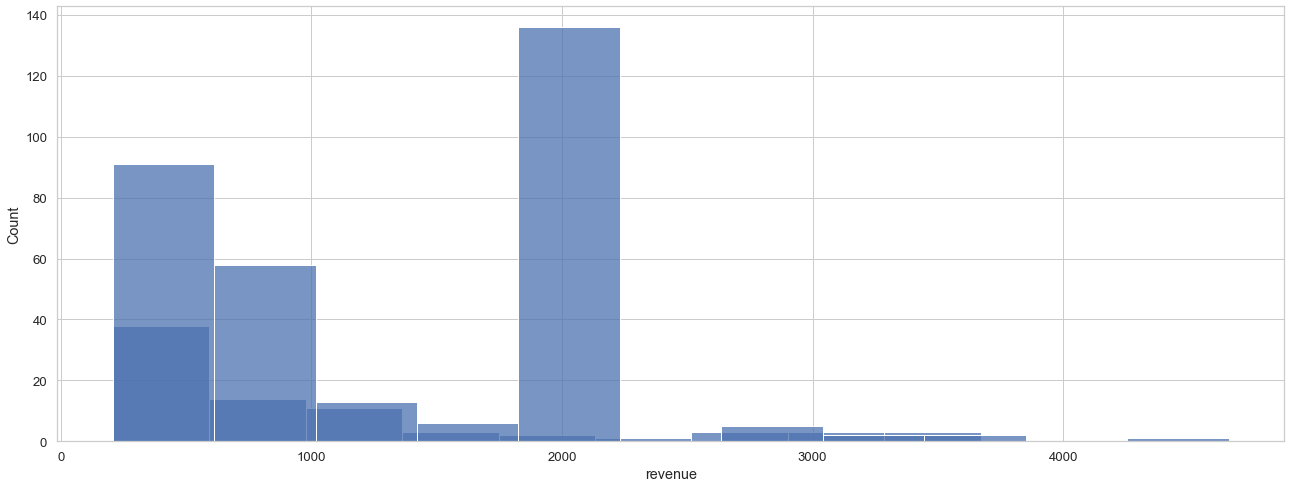

In [25]:
sns.histplot(ac_control.revenue)
sns.histplot(ac_test.revenue)

Группы существенно различаются и тестовая группа заметно превосходит контрольную. Есть довольно большие выбросы.
За счет локального максимума в районе 2000 - кажется, что в тестовой группе (В) выручка выше.

### Выбор метрик: <a id='metrica'></a>

Выбор должен быть основан на конечной цели проведения эксперимента. В данном случае цель это увеличение выручки. Ее в данном случае можно увеличить за счет роста суммы покупок (среднего чека).

In [26]:
print('Контроль (mean)','\n',ac_control.groupby('country').agg({'revenue':'mean'}),'\n')
print('Контроль (median)','\n',ac_control.groupby('country').agg({'revenue':'median'}),'\n')
print('Тест (mean)','\n',ac_test.groupby('country').agg({'revenue':'mean'}),'\n')
print('Тест (median)','\n',ac_test.groupby('country').agg({'revenue':'median'}),'\n')

Контроль (mean) 
              revenue
country             
Russia    823.418605
Sweden   1091.171429 

Контроль (median) 
          revenue
country         
Russia     590.0
Sweden     698.0 

Тест (mean) 
              revenue
country             
Russia   1215.441624
Sweden   1356.162393 

Тест (median) 
          revenue
country         
Russia    1001.0
Sweden    1908.0 



Медианный платеж оказался выше среднего платежа - 
Такое могло получиться, если справа от медианы платежи были немного больше медианы, а слева они находились от медианы "дальше".
Не считая этого перекоса, можно сделать предположение о том, что значения revenue выражены в единой валюте.

Посчитаем медианную выручку с заплатившего пользователя, так как есть выбросы, и cреднюю выручку по группе.

### 3) Средняя выручка с заплатившего пользователя: <a id='mean'></a>

Сформулируем гипотезы:
- **Н0**: Средняя выручка с заплатившего пользователя в контрольной и тестовой группе одинакова
- **Н1**: Средняя выручка с заплатившего пользователя в контрольной и тестовой группе не одинакова

In [27]:
#средний доход с пользователя(ARPU)

active_users_purchases_gr.groupby('group').agg({'revenue': 'mean'}) 

,revenue
group,
A,870.672897
B,1118.836406


Среднее по тестовой группе выше, чем в контрольной. Посмотрим на выручку по группам на графике и все распределение.

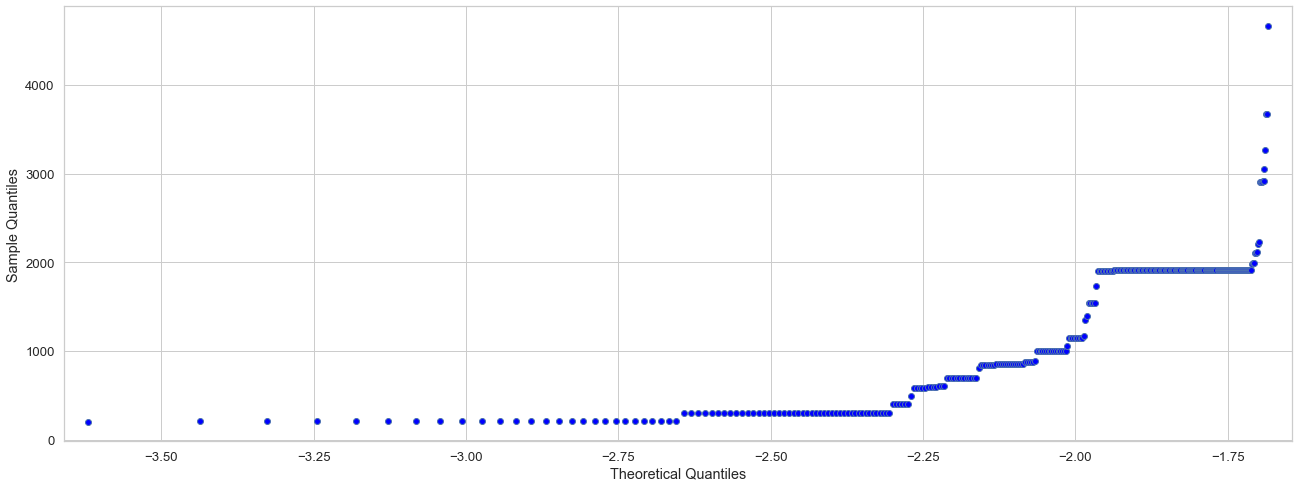

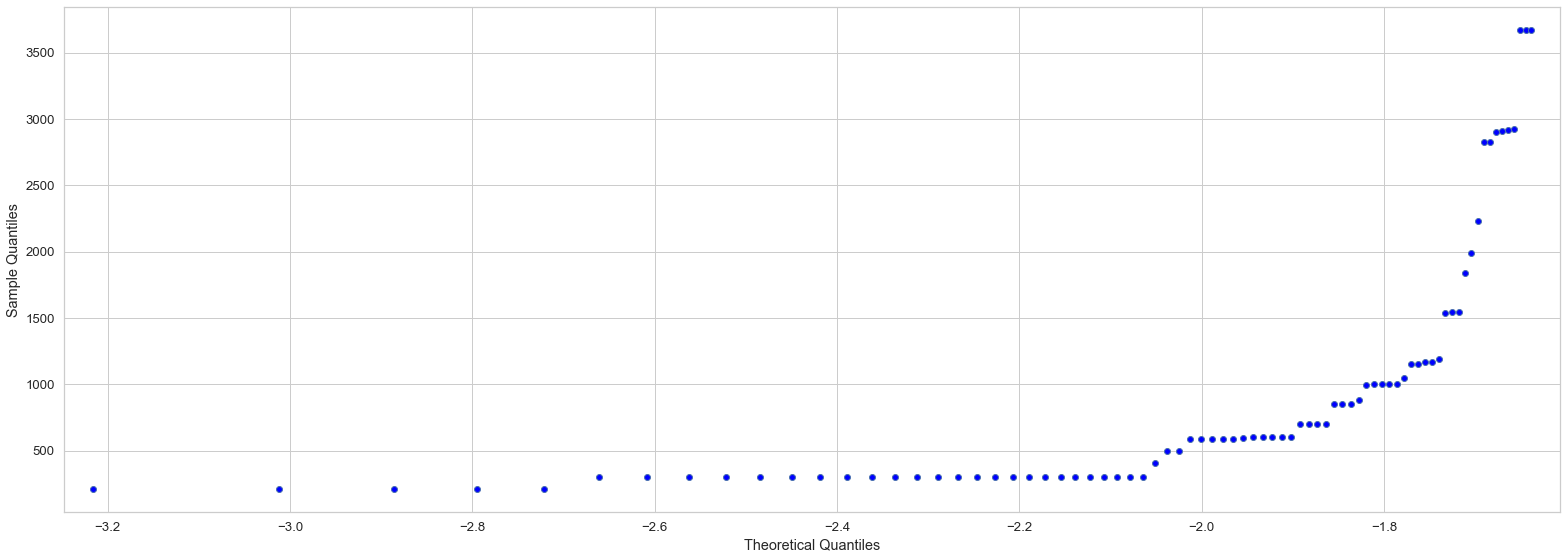

In [28]:
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(22,8)}
)
sm.qqplot(test.revenue, line='s')
sm.qqplot(control.revenue, line='s')
plt.tight_layout()
plt.show()

Распределения выглядит как ненормальные, кроме того есть большое количество одинаковых значений, есть значительные выбросы.
Попробуем их нормализовать с помощью логарифмирования значений и проверим тестом Шапиро-Уилка.


Гипотезы:
- **Н0**: Выборка получена из нормального распределения
- **Н1**: Выборка получена из распределения, не являющимся нормальным

0.843480110168457 3.5538253301344334e-17
Распределение не нормальное (Отклоняем H0)


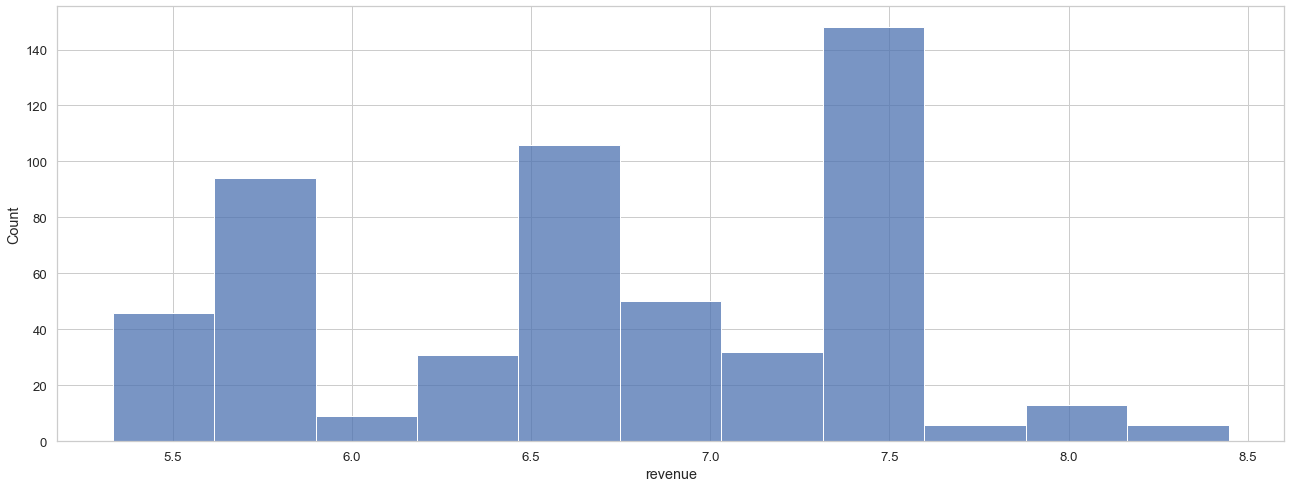

In [29]:
sns.histplot(np.log(active_users_purchases_gr.revenue))
stat, p = stats.shapiro(np.log(ac_test.revenue))
print(stat, p)
alpha = 0.05
if p > alpha:
    print('Распределение нормальное (Не отклоняем H0)')
else:
    print('Распределение не нормальное (Отклоняем H0)')

0.7358548641204834 1.5417730980793465e-10
Распределение не нормальное (Отклоняем H0)


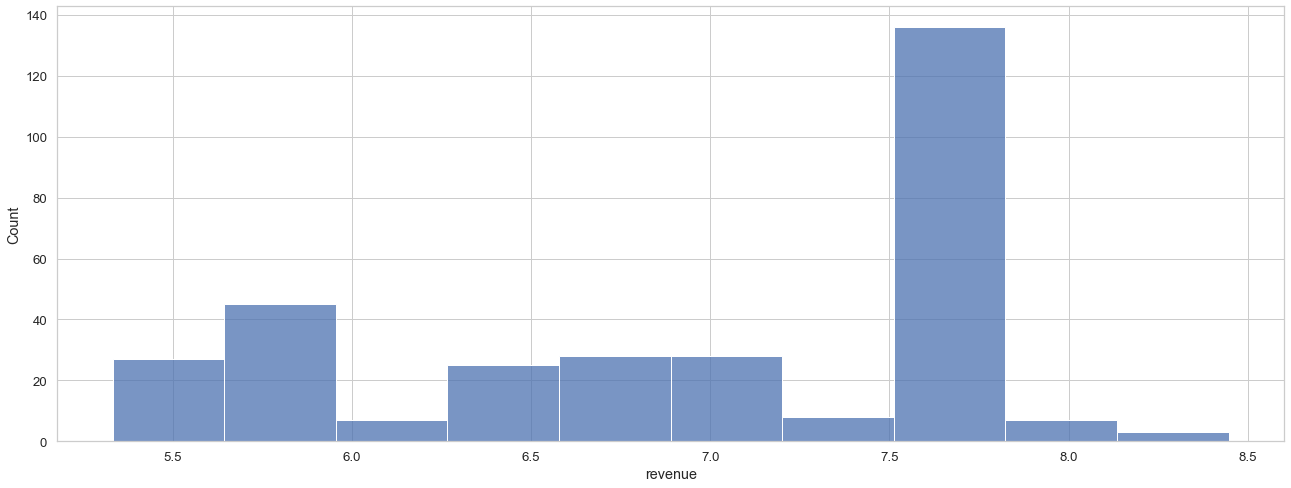

In [30]:
sns.histplot(np.log(ac_test.revenue))
stat, p = stats.shapiro(ac_control.revenue)
print(stat, p)
alpha = 0.05
if p > alpha:
    print('Распределение нормальное (Не отклоняем H0)')
else:
    print('Распределение не нормальное (Отклоняем H0)')

P-value оказался меньше 0.05 и нулевая гипотеза была отклонена.
Что мы имеем: 
- **Количественный тип данных**

- **Данные распределены ненормально**

- **Группы независимы**

- **Сравниваем две группы**

Мог бы подойти U-критерий Манна-Уитни, но для его применения в выборках не должно быть одинаковых значений, а на Q-Q Plot они они были явно заметны.
Проверим дополнительно:

In [31]:
control.groupby('revenue',as_index=False)\
    .agg({'group' : 'count'}).head(10)

,revenue,group
0,208.0,5
1,298.0,4
2,299.0,3
3,300.0,9
4,301.0,7
5,302.0,2
6,410.0,1
7,498.0,1
8,499.0,1
9,589.0,2


In [32]:
test.groupby('revenue',as_index=False)\
    .agg({'group' : 'count'}).head(10)

,revenue,group
0,207.0,1
1,208.0,8
2,209.0,11
3,210.0,5
4,211.0,2
5,298.0,4
6,299.0,9
7,300.0,13
8,301.0,15
9,302.0,4


In [33]:
control.query('revenue == 301.0')

,user_id,country,platform,sex,group,revenue
97,3423,Sweden,ios,male,A,301.0
287,6308,Sweden,ios,male,A,301.0
684,5840,Sweden,android,female,A,301.0
907,6663,Sweden,android,female,A,301.0
1208,1469,Russia,ios,female,A,301.0
1246,8263,Russia,ios,female,A,301.0
1451,3798,Russia,ios,male,A,301.0


In [34]:
test.query('revenue == 301.0')


,user_id,country,platform,sex,group,revenue
178,3934,Russia,android,female,B,301.0
861,7444,Sweden,android,female,B,301.0
1091,3856,Russia,ios,female,B,301.0
2652,7311,Russia,ios,female,B,301.0
3088,3157,Russia,ios,male,B,301.0
3382,2061,Russia,android,male,B,301.0
3425,4324,Russia,ios,female,B,301.0
3459,5845,Russia,ios,male,B,301.0
3842,3041,Sweden,ios,male,B,301.0
4020,8044,Russia,android,female,B,301.0


Видно что, например, значение 301.0 повторяется как внутри каждой группы, так и между группами.
Подведем итог: количественные данные распределены ненормальным образом, трансформирование переменной не помогло, условие для применения критерия Манна-Уитни не выполняется.
Размеры групп значительно отличаются друг от друга.
Лучшим решением в такой ситуации будет применить Bootstrap

### Применение Bootstrap <a id='boot'></a>


Гипотезы:
- **Н0**: средняя выручка в контрольной и тестовой группе одинакова
- **Н1**: средняя выручка в контрольной и тестовой группе не одинакова

In [35]:
def get_bootstrap(
        data_column_1, # контрольная группа
        data_column_2, # тестовая группа
        boot_it = 1000, # количество подвыборок
        statistic = np.mean, # проверяем гипотезу об увеличении среднего чека
        bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)]) # уравниваем размер выборок, взяв максимум
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки для контрольной и тестовой групп
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True # значения обязательно должны вернуться в выборку
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values

        boot_data.append(statistic(samples_1-samples_2)) # берём среднее от распределения разностей и добавляем в переменную

    pd_boot_data = pd.DataFrame(boot_data) # собираем датафрейм из средних

    # Считаем доверительный интервал для среднего. Если он попадёт в 0, то при уровне значимости
    # в 95% мы примем нулевую гипотезу
    # Используем перцентильный метод расчета доверительного интервала. Для этого берем 95% площади распределния,
    # вычислив 2.5 и 97.5 перцентили в бут-распределнии.

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    # Вычисляем p-value по нормальному распределению

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)

    plt.vlines(ci,ymin=0,ymax=80,linestyle='--')
    plt.xlabel('boot_data', fontsize = 15)
    plt.ylabel('frequency', fontsize = 15)
    plt.title("Histogram of boot_data", fontsize = 18, pad = 50)
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

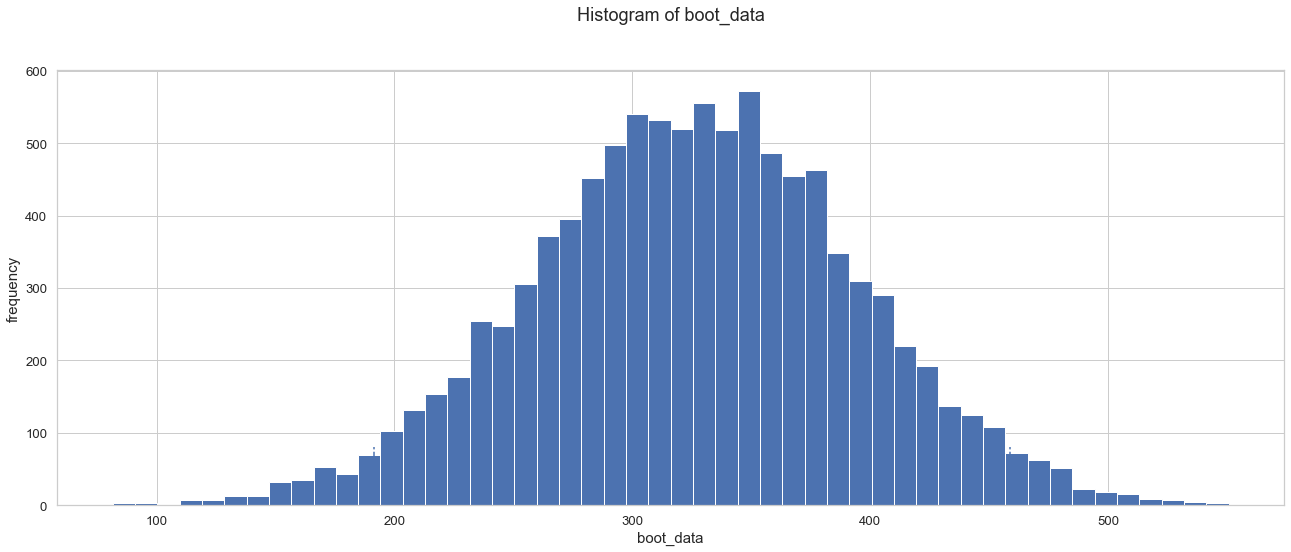

In [36]:
booted_data = get_bootstrap(
    ac_test.revenue, ac_control.revenue, boot_it = 10000)

In [37]:
booted_data['ci']

,0
0.025,191.579618
0.975,458.667118


In [39]:
booted_data['p_value']
if p > alpha:
    print('Значимые различия не обнаружены')
else:
    print('Значимые различия обнаружены')

Значимые различия обнаружены


Различия средних выручек оказались статистически значимы и доверительный интервал не попал в 0 - это означает, что отвергается нулевая гипотеза.

### Медианная выручка с заплатившего пользователя <a id='median'></a>

In [40]:
active_users_purchases_gr.groupby('group').agg({'revenue': 'median'}) #медианный доход с пользователя

,revenue
group,
A,698.0
B,944.0


Гипотезы:
- **Н0**: Медианная выручка с заплатившего пользователя в контрольной и тестовой группе одинакова
- **Н1**: Медианная выручка с заплатившего пользователя в контрольной и тестовой группе не одинакова

Попробуем применить непараметрический критерий Манна-Уитни:

In [41]:
mannwhitneyu(ac_test.revenue, ac_control.revenue)
print(stat, p)
alpha = 0.05
if p > alpha:
    print('Значимые различия не обнаружены')
else:
    print('Значимые различия обнаружены')

0.7358548641204834 1.5417730980793465e-10
Значимые различия обнаружены


Значимые различия обнаружены.

Теперь проверим полученный результат методом bootstrap по медианам и средним:

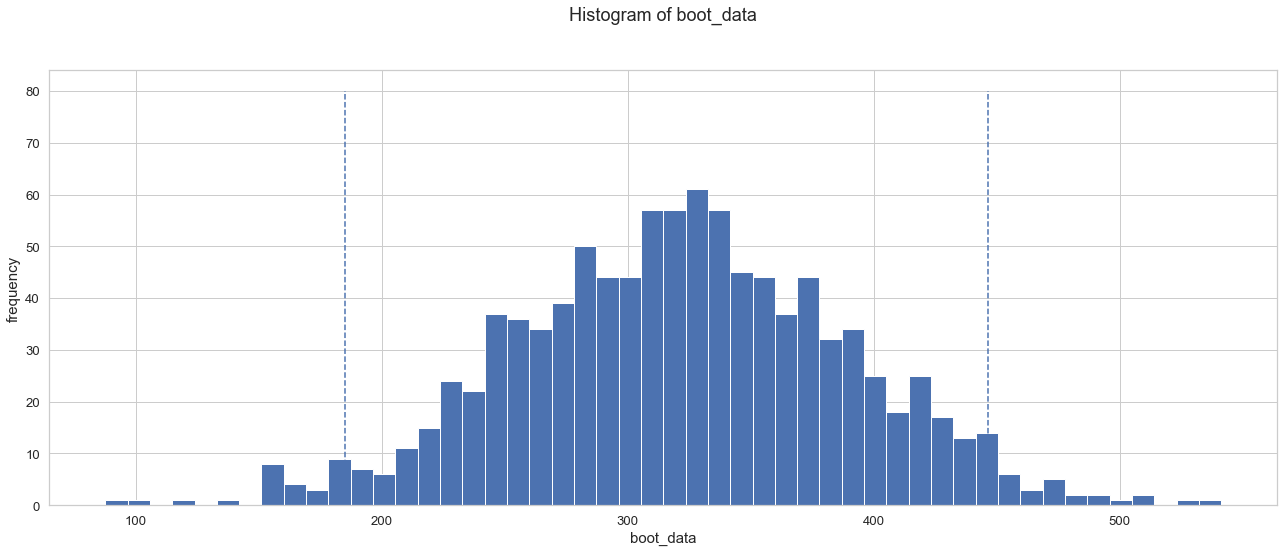

In [282]:
boot1 = get_bootstrap(
    ac_test.revenue, 
    ac_control.revenue, 
    boot_it=1000, 
    statistic=np.mean, 
    bootstrap_conf_level=0.95 
)

In [285]:
boot1["p_value"]
alpha = 0.05
if p > alpha:
    print('Значимые различия не обнаружены')
else:
    print('Значимые различия обнаружены')

Значимые различия обнаружены


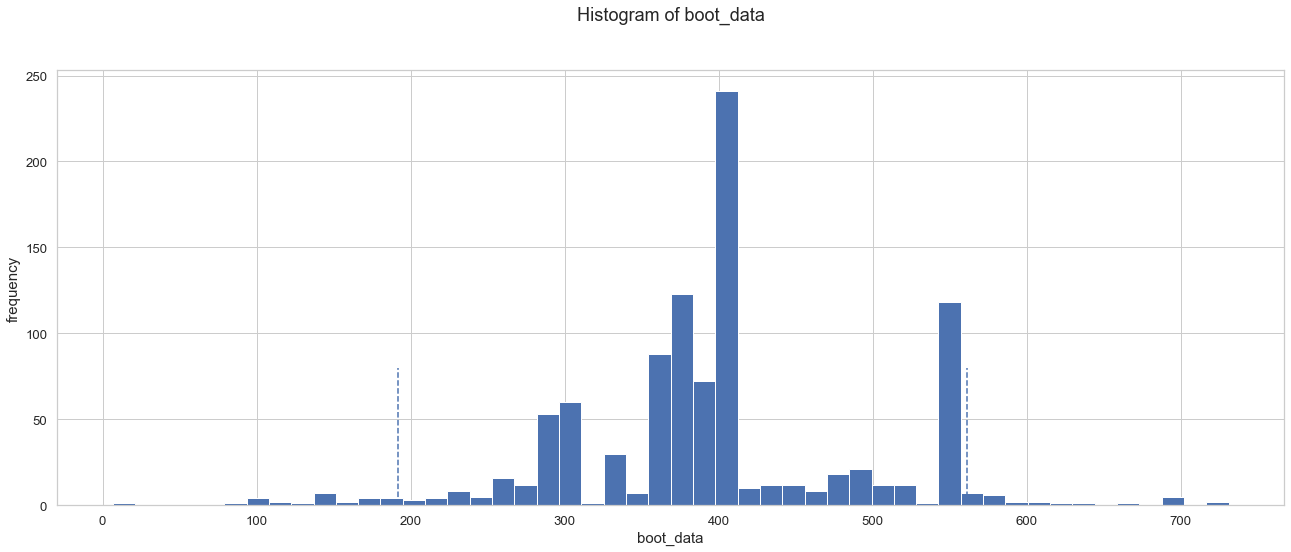

In [42]:
boot2 = get_bootstrap(
    ac_test.revenue, 
    ac_control.revenue, 
    boot_it=1000, 
    statistic=np.median, 
    bootstrap_conf_level=0.95 
)

In [43]:
boot2["p_value"]
alpha = 0.05
if p > alpha:
    print('Значимые различия не обнаружены')
else:
    print('Значимые различия обнаружены')

Значимые различия обнаружены


Значимость различий в медианной выручке подтвердилась.

**Выводы** <a id='con'></a>


В задании были рассмотрены результаты А/В теста по следующим метрикам:

- Средняя выручка по группе (ARPU)

- Медианная выручка с заплатившего пользователя.

При проведении A/B теста произошло нарушение сплитования, из-за чего возможно в тестовую группу попало меньше пользоватенлей из Швеции, чем из России.
Для недопущения подобных проблем следует проводить A/A тестирование.

По первой метрике статистически значимые различия были выявлены, и гипотеза  о том,
что новая модель оплаты действительно повлияла на увеличение среднего чека, подтвердилась.
Вторая метрика также показала статистически значимые различия.
Получили значимые различия в распределении средней выручки и медианного дохода на пользователя. 
В выборках тестовой и контрольных групп существовала диспропорция по странам. 


**Решение - выкатываем новую модель оплаты на всех пользователей**